In [12]:
#看看将数据集按年龄或者婚姻分类后预测结果
# -*- coding: UTF-8 -*-
import pandas as pd
import numpy as np
import numpy.core.umath_tests
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [13]:
'''
df1 = pd.read_csv('data/cleaned.csv')
df1.sort_values("User_ID",inplace=True)
df1=df1.reset_index(drop=True)
df1.drop(['Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1,inplace=True)
tmp_df1 = df1[['User_ID','Purchase']]
tmp_df2 = df1[['User_ID','Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status']]

tmp_df = tmp_df1.groupby('User_ID').sum()
tmp_df2=tmp_df2.drop_duplicates(['User_ID'])
tmp_df2.sort_values("User_ID",inplace=True)
tmp_df2=tmp_df2.reset_index(drop=True)

tmp_df=tmp_df.reset_index(drop=True)
df = pd.concat([tmp_df2,tmp_df['Purchase']],axis=1)
print(df['Purchase'].mean())
'''
df = pd.read_csv('data/cleaned.csv')

In [14]:
#特征工程 解决编码问题
#User_ID和Product_ID使用序号，Gender和Marray使用二元类型，其他使用热编码
le_U_ID = LabelEncoder()
df['User_ID'] = le_U_ID.fit_transform(df['User_ID'])
le_P_ID = LabelEncoder()
df['Gender'] = np.where(df['Gender']=='M',1,0) # Female: 0, Male: 1
df_Age = pd.get_dummies(df.Age)
df_CC = pd.get_dummies(df.City_Category)
df_SIC = pd.get_dummies(df.Stay_In_Current_City_Years)
df_encoded = pd.concat([df,df_Age,df_CC,df_SIC],axis=1)
df_encoded.drop(['Age','City_Category','Stay_In_Current_City_Years'],axis=1,inplace=True)
df_ocup = pd.get_dummies(df.Occupation)
df_encoded = pd.concat([df_encoded,df_ocup],axis=1)
df_encoded.drop(['Occupation'],axis=1,inplace=True)
print(df_encoded.dtypes)
print(df_encoded.head(5))

User_ID                 int64
Product_ID             object
Gender                  int32
Marital_Status          int64
Product_Category_1      int64
Product_Category_2    float64
Product_Category_3    float64
Purchase                int64
0-17                    uint8
18-25                   uint8
26-35                   uint8
36-45                   uint8
46-50                   uint8
51-55                   uint8
55+                     uint8
A                       uint8
B                       uint8
C                       uint8
0                       uint8
1                       uint8
2                       uint8
3                       uint8
4+                      uint8
0                       uint8
1                       uint8
2                       uint8
3                       uint8
4                       uint8
5                       uint8
6                       uint8
7                       uint8
8                       uint8
9                       uint8
10        

In [15]:
df_Female=df_encoded[df_encoded['Gender']==1]
df_Male=df_encoded[df_encoded['Gender']==0]
df_Marry=df_encoded[df_encoded['Marital_Status']==1]
df_Unmarry=df_encoded[df_encoded['Marital_Status']==0]
print(df_Unmarry)

        User_ID Product_ID  Gender  Marital_Status  Product_Category_1  \
0             0  P00069042       0               0                   3   
1             0  P00248942       0               0                   1   
2             0  P00087842       0               0                  12   
3             0  P00085442       0               0                  12   
4             1  P00285442       1               0                   8   
5             2  P00193542       1               0                   1   
14            5  P00231342       0               0                   5   
15            5  P00190242       0               0                   4   
16            5   P0096642       0               0                   2   
17            5  P00058442       0               0                   5   
25            8  P00135742       1               0                   6   
26            8  P00039942       1               0                   8   
27            8  P00161442       1    

In [16]:
df_frac_Male = df_Male.sample(frac=0.02,random_state=100)
#X_Male = df_frac_Male.drop(['Purchase','User_ID'], axis=1)
X_Male = df_frac_Male.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y_Male = df_frac_Male['Purchase']
X_train_Male,X_test_Male,y_train_Male,y_test_Male = train_test_split(X_Male,y_Male,random_state=100)

df_frac_Female = df_Female.sample(frac=0.02,random_state=100)
#X_Female = df_frac_Female.drop(['Purchase','User_ID'], axis=1)
X_Female = df_frac_Female.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y_Female = df_frac_Female['Purchase']
X_train_Female,X_test_Female,y_train_Female,y_test_Female = train_test_split(X_Female,y_Female,random_state=100)

df_frac_Marry = df_Marry.sample(frac=0.02,random_state=100)
#X_Marry = df_frac_Marry.drop(['Purchase','User_ID'], axis=1)
X_Marry = df_frac_Marry.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y_Marry = df_frac_Marry['Purchase']
X_train_Marry,X_test_Marry,y_train_Marry,y_test_Marry = train_test_split(X_Marry,y_Marry,random_state=100)

df_frac_Unmarry = df_Unmarry.sample(frac=0.02,random_state=100)
#X_Unmarry = df_frac_Unmarry.drop(['Purchase','User_ID'], axis=1)
X_Unmarry = df_frac_Unmarry.drop(['Purchase','User_ID','Product_ID','Product_Category_1','Product_Category_2','Product_Category_3'], axis=1)
y_Unmarry = df_frac_Unmarry['Purchase']
X_train_Unmarry,X_test_Unmarry,y_train_Unmarry,y_test_Unmarry = train_test_split(X_Unmarry,y_Unmarry,random_state=100)


In [17]:
param_grid = {'n_estimators':[1,3,10,30,100,150,300,400,500],'max_depth':[1,3,5,7,9,11]}
grid_rf_Male = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_Male,y_train_Male)
grid_rf_Female = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_Female,y_train_Female)
grid_rf_Marry = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_Marry,y_train_Marry)
grid_rf_Unmarry = GridSearchCV(RandomForestRegressor(),param_grid,cv=10,scoring='neg_mean_squared_error').fit(X_train_Unmarry,y_train_Unmarry)

In [18]:
print('Male Best parameter: {}'.format(grid_rf_Male.best_params_))
print('Male Best score: {:.2f}'.format((-1*grid_rf_Male.best_score_)**0.5))

print('Female Best parameter: {}'.format(grid_rf_Female.best_params_))
print('Female Best score: {:.2f}'.format((-1*grid_rf_Female.best_score_)**0.5))

print('Marry Best parameter: {}'.format(grid_rf_Marry.best_params_))
print('Marry Best score: {:.2f}'.format((-1*grid_rf_Marry.best_score_)**0.5))

print('Unmarry Best parameter: {}'.format(grid_rf_Unmarry.best_params_))
print('Unmarry Best score: {:.2f}'.format((-1*grid_rf_Unmarry.best_score_)**0.5))

Male Best parameter: {'max_depth': 1, 'n_estimators': 10}
Male Best score: 4751.52
Female Best parameter: {'max_depth': 7, 'n_estimators': 30}
Female Best score: 4996.71
Marry Best parameter: {'max_depth': 3, 'n_estimators': 10}
Marry Best score: 4940.89
Unmarry Best parameter: {'max_depth': 5, 'n_estimators': 300}
Unmarry Best score: 4952.79


In [19]:
train_sizes_Male, train_scores_Male, valid_scores_Male = learning_curve(RandomForestRegressor(max_depth=1, n_estimators=10), X_train_Male, y_train_Male, cv=10, scoring='neg_mean_squared_error')

train_sizes_Female, train_scores_Female, valid_scores_Female = learning_curve(RandomForestRegressor(max_depth=7, n_estimators=30), X_train_Female, y_train_Female, cv=10, scoring='neg_mean_squared_error')

train_sizes_Marry, train_scores_Marry, valid_scores_Marry = learning_curve(RandomForestRegressor(max_depth=3, n_estimators=10), X_train_Marry, y_train_Marry, cv=10, scoring='neg_mean_squared_error')

train_sizes_Unmarry, train_scores_Unmarry, valid_scores_Unmarry = learning_curve(RandomForestRegressor(max_depth=5, n_estimators=300), X_train_Unmarry, y_train_Unmarry, cv=10, scoring='neg_mean_squared_error')


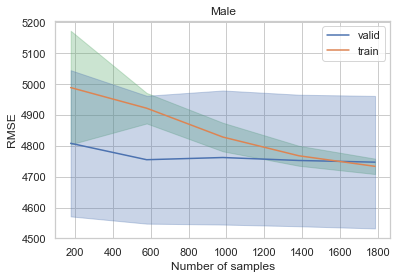

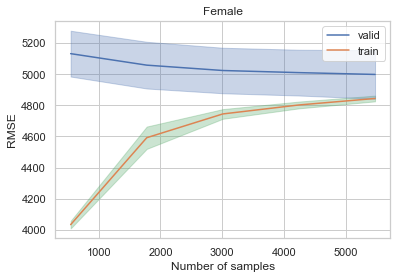

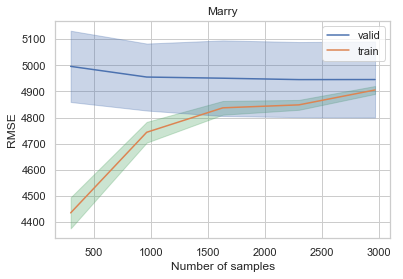

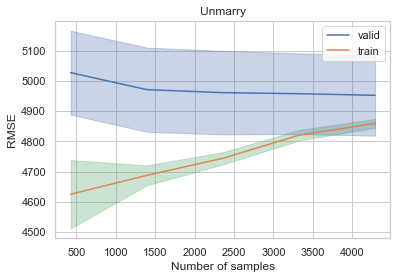

In [20]:
train_scores_Male = (-1*train_scores_Male)**0.5
valid_scores_Male = (-1*valid_scores_Male)**0.5
train_scores_mean_Male = np.mean(train_scores_Male, axis=1)
train_scores_std_Male = np.std(train_scores_Male, axis=1)
valid_scores_mean_Male = np.mean(valid_scores_Male, axis=1)
valid_scores_std_Male = np.std(valid_scores_Male, axis=1)

plt.figure()
plt.plot(train_sizes_Male,valid_scores_mean_Male,label='valid')
plt.plot(train_sizes_Male,train_scores_mean_Male,label='train')
plt.fill_between(train_sizes_Male, train_scores_mean_Male - train_scores_std_Male, train_scores_mean_Male + train_scores_std_Male, alpha=0.3,color="g")
plt.fill_between(train_sizes_Male, valid_scores_mean_Male - valid_scores_std_Male,valid_scores_mean_Male + valid_scores_std_Male, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.title('Male')
plt.legend()


train_scores_Female = (-1*train_scores_Female)**0.5
valid_scores_Female = (-1*valid_scores_Female)**0.5
train_scores_mean_Female = np.mean(train_scores_Female, axis=1)
train_scores_std_Female = np.std(train_scores_Female, axis=1)
valid_scores_mean_Female = np.mean(valid_scores_Female, axis=1)
valid_scores_std_Female = np.std(valid_scores_Female, axis=1)

plt.figure()
plt.plot(train_sizes_Female,valid_scores_mean_Female,label='valid')
plt.plot(train_sizes_Female,train_scores_mean_Female,label='train')
plt.fill_between(train_sizes_Female, train_scores_mean_Female - train_scores_std_Female, train_scores_mean_Female + train_scores_std_Female, alpha=0.3,color="g")
plt.fill_between(train_sizes_Female, valid_scores_mean_Female - valid_scores_std_Female,valid_scores_mean_Female + valid_scores_std_Female, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.title('Female')
plt.legend()


train_scores_Marry = (-1*train_scores_Marry)**0.5
valid_scores_Marry = (-1*valid_scores_Marry)**0.5
train_scores_mean_Marry = np.mean(train_scores_Marry, axis=1)
train_scores_std_Marry = np.std(train_scores_Marry, axis=1)
valid_scores_mean_Marry = np.mean(valid_scores_Marry, axis=1)
valid_scores_std_Marry = np.std(valid_scores_Marry, axis=1)

plt.figure()
plt.plot(train_sizes_Marry,valid_scores_mean_Marry,label='valid')
plt.plot(train_sizes_Marry,train_scores_mean_Marry,label='train')
plt.fill_between(train_sizes_Marry, train_scores_mean_Marry - train_scores_std_Marry, train_scores_mean_Marry + train_scores_std_Marry, alpha=0.3,color="g")
plt.fill_between(train_sizes_Marry, valid_scores_mean_Marry - valid_scores_std_Marry,valid_scores_mean_Marry + valid_scores_std_Marry, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.title('Marry')
plt.legend()


train_scores_Unmarry = (-1*train_scores_Unmarry)**0.5
valid_scores_Unmarry = (-1*valid_scores_Unmarry)**0.5
train_scores_mean_Unmarry = np.mean(train_scores_Unmarry, axis=1)
train_scores_std_Unmarry = np.std(train_scores_Unmarry, axis=1)
valid_scores_mean_Unmarry = np.mean(valid_scores_Unmarry, axis=1)
valid_scores_std_Unmarry = np.std(valid_scores_Unmarry, axis=1)

plt.figure()
plt.plot(train_sizes_Unmarry,valid_scores_mean_Unmarry,label='valid')
plt.plot(train_sizes_Unmarry,train_scores_mean_Unmarry,label='train')
plt.fill_between(train_sizes_Unmarry, train_scores_mean_Unmarry - train_scores_std_Unmarry, train_scores_mean_Unmarry + train_scores_std_Unmarry, alpha=0.3,color="g")
plt.fill_between(train_sizes_Unmarry, valid_scores_mean_Unmarry - valid_scores_std_Unmarry,valid_scores_mean_Unmarry + valid_scores_std_Unmarry, alpha=0.3, color="b")
plt.xlabel('Number of samples')
plt.ylabel('RMSE')
plt.title('Unmarry')
plt.legend()

Text(0.5,0,'relative importance')

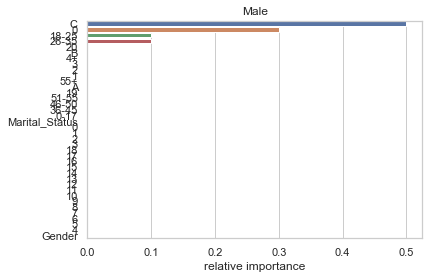

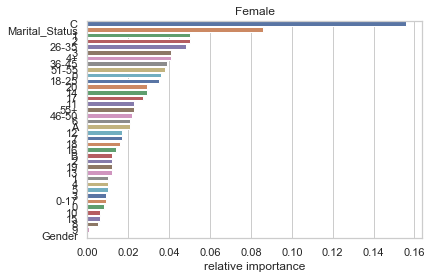

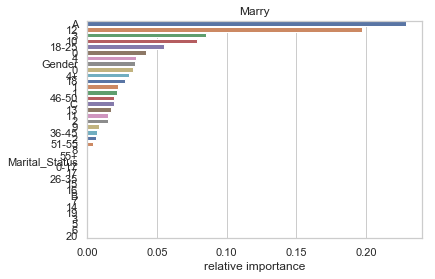

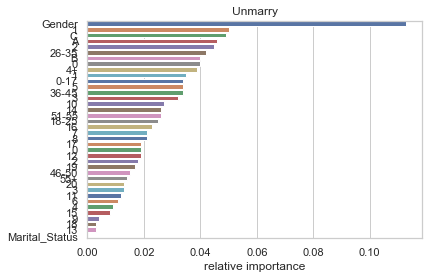

In [27]:
rf_Male = RandomForestRegressor(max_depth=1, n_estimators=10).fit(X_train_Male,y_train_Male)
f_im_Male = rf_Male.feature_importances_.round(3)
ser_rank_Male = pd.Series(f_im_Male,index=X_Male.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank_Male.index,x=ser_rank_Male.values,palette='deep')
plt.title('Male')
plt.xlabel('relative importance')

rf_Female = RandomForestRegressor(max_depth=7, n_estimators=30).fit(X_train_Female,y_train_Female)
f_im_Female = rf_Female.feature_importances_.round(3)
ser_rank_Female = pd.Series(f_im_Female,index=X_Female.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank_Female.index,x=ser_rank_Female.values,palette='deep')
plt.title('Female')
plt.xlabel('relative importance')

rf_Marry = RandomForestRegressor(max_depth=3, n_estimators=10).fit(X_train_Marry,y_train_Marry)
f_im_Marry = rf_Marry.feature_importances_.round(3)
ser_rank_Marry = pd.Series(f_im_Marry,index=X_Marry.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank_Marry.index,x=ser_rank_Marry.values,palette='deep')
plt.title('Marry')
plt.xlabel('relative importance')

rf_Unmarry = RandomForestRegressor(max_depth=5, n_estimators=300).fit(X_train_Unmarry,y_train_Unmarry)
f_im_Unmarry = rf_Unmarry.feature_importances_.round(3)
ser_rank_Unmarry = pd.Series(f_im_Unmarry,index=X_Unmarry.columns).sort_values(ascending=False)

plt.figure()
sns.barplot(y=ser_rank_Unmarry.index,x=ser_rank_Unmarry.values,palette='deep')
plt.title('Unmarry')
plt.xlabel('relative importance')

In [28]:
y_predicted_Male = rf_Male.predict(X_test_Male)
print('Male Test set RMSE: {:.3f}'.format(mean_squared_error(y_test_Male,y_predicted_Male)**0.5))

y_predicted_Female = rf_Female.predict(X_test_Female)
print('Female Test set RMSE: {:.3f}'.format(mean_squared_error(y_test_Female,y_predicted_Female)**0.5))

y_predicted_Marry = rf_Marry.predict(X_test_Marry)
print('Marry Test set RMSE: {:.3f}'.format(mean_squared_error(y_test_Marry,y_predicted_Marry)**0.5))

y_predicted_Unmarry = rf_Unmarry.predict(X_test_Unmarry)
print('Unmarry Test set RMSE: {:.3f}'.format(mean_squared_error(y_test_Unmarry,y_predicted_Unmarry)**0.5))

Male Test set RMSE: 4706.875
Female Test set RMSE: 5132.161
Marry Test set RMSE: 5047.171
Unmarry Test set RMSE: 5017.173
